# Project Review 2 
## Exploration of Correlation between spike in releases and new vulnerabilities
### Gabriel Wilmoth
#### Basic Library Imports (Run First)

In [11]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from pandas.io.json import json_normalize
import datetime as dt
import glob
import statistics as stat
from scipy.stats import norm
from scipy import stats
from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = [16,9]

### Reading in Release CSV

In [2]:
release_header = ['id', 'target', 'date', 'date_offset', 'name', 'comment', 'author']
# Path to release.csv, and whether to select uncompressed or ocmpressed version
# release_path = 'D:/data/open_source/release.csv'
release_path = 'C:\\Users\\Faugh\\Desktop\\DataScienceData\\popular-3k-python\\release.csv'

In [3]:
def hex_str(str):
    return bytes.fromhex((str).replace('\\x','')).decode('utf-8')

def date_str(str):
    return pd.to_datetime(str, format='%Y-%m-%dT%H:%M:%S.000Z')

In [4]:
release_df = pd.read_csv(release_path, names=release_header, converters={'date':date_str,'comment':hex_str})
release_df = release_df[['id','date','name','comment','author']]

In [5]:
release_df.head()

,id,date,name,comment,author
0,\xae671a0067dbeabbc3cb546705edc1f81f71a193,2015-02-03 21:58:44,\x72656c656173652d323031352d30322d3034,"Release for February 4th, 2015\n",91949
1,\x33e2c27d1ec224a54ed7ca4a6e09c352e92a227d,2013-07-05 04:58:14,\x76302e32392e31,tag version 0.29.1\n,140982
2,\x1f9bcd823807f41afaab6b74b34473531ca7eb30,2013-03-29 13:02:20,\x76332e302e30,What's new in Tornado 3.0\n===================...,207066
3,\x3206fb28a040494bac6973310e7f21f031989da6,2010-12-09 04:14:19,\x6275696c642d343639,Windows build SickBeard-win32-alpha-build469\n,875380
4,\x652fc27cf9fe9262d2c941d6385043efa41016da,2011-11-08 01:22:48,\x312e312e36,Fabric 1.1.6\n,63770


### Reading in NVD CSV's

In [39]:
def import_nvd():
    path = '../../DataScienceData/NVDDataset/'
    all_nvds = glob.glob(path+'*.json')
    l = []
    
    for filename in all_nvds:
        nvd_df = pd.read_json(filename)
        nvd_df = clean_nvd(nvd_df)
        l.append(nvd_df)
    
    return pd.concat(l, ignore_index=True)

def clean_nvd(df):
    df = json_normalize(df['CVE_Items'])
    df = df[['cve.CVE_data_meta.ID', 'publishedDate', 'impact.baseMetricV2.cvssV2.baseScore']]
    df.columns = ['cve_id', 'published_date', 'base_score']
    df['published_date'] = df['published_date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%dT%H:%MZ'))
    df = df[(df['published_date'] >= '2005-07-07') & (df['published_date'] < '2018-10-01')]
    
    return df

In [40]:
vulns = import_nvd()
print(vulns.head())

          cve_id      published_date  base_score
0  CVE-1999-1593 2009-01-15 01:30:00         7.6
1  CVE-2000-1245 2010-04-05 15:30:00         7.5
2  CVE-2000-1246 2010-04-05 15:30:00         3.5
3  CVE-2000-1247 2011-10-05 02:56:00         2.1
4  CVE-2000-1254 2016-05-05 01:59:00         5.0


In [41]:
vulns.head(20)

,cve_id,published_date,base_score
0,CVE-1999-1593,2009-01-15 01:30:00,7.6
1,CVE-2000-1245,2010-04-05 15:30:00,7.5
2,CVE-2000-1246,2010-04-05 15:30:00,3.5
3,CVE-2000-1247,2011-10-05 02:56:00,2.1
4,CVE-2000-1254,2016-05-05 01:59:00,5.0
5,CVE-2001-0654,2017-05-11 14:29:00,NaN
6,CVE-2001-0655,2017-05-11 14:29:00,NaN
7,CVE-2001-0656,2017-05-11 14:29:00,NaN
8,CVE-2001-0657,2017-05-11 14:29:00,NaN
9,CVE-2001-0798,2017-05-11 14:29:00,NaN


### Measure of Vulnerabilities Per Week

In [96]:
vulnsWeekCount = pd.DataFrame()
vulnsWeekCount['count'] = vulns['published_date'].value_counts().resample('w').apply('count')
vulnsWeekCount.head()

,count
2005-07-10,3
2005-07-17,4
2005-07-24,3
2005-07-31,3
2005-08-07,6


#### -Plotting of New Vulnerabilities by Week

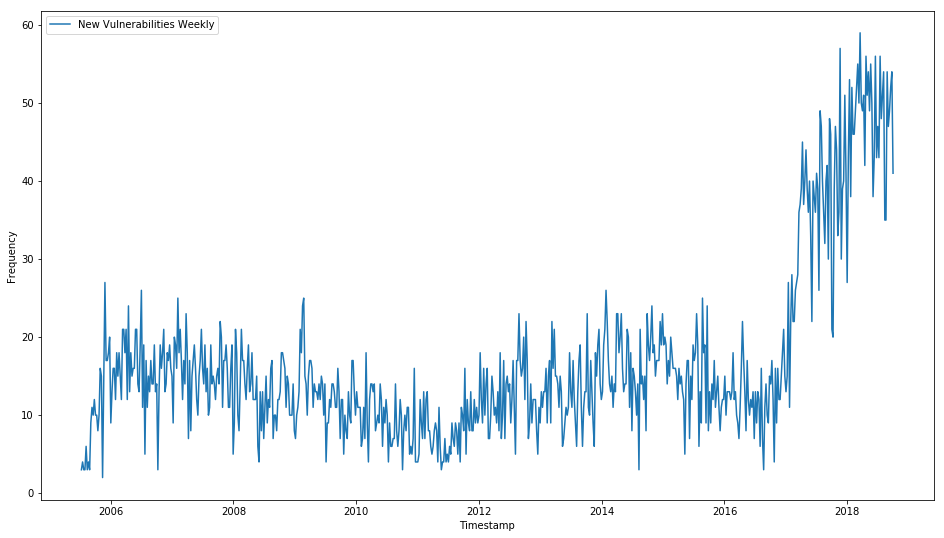

In [54]:
#vulnsWeekCount.plot()
plt.plot(vulnsWeekCount, label='New Vulnerabilities Weekly')
plt.legend(loc='upper left')
plt.xlabel('Timestamp')
plt.ylabel('Frequency')
plt.show()

#### -Basic Statistics on New Vulnerabilties (Weekly)
       - Mean: 16.60781476121563
       - Median: 14.0
       - Variance: 125.13727217433251
       - Standard Deviation: 11.186477201261017

In [97]:
vulnsWeekCount_mean = vulnsWeekCount['count'].mean()
vulnsWeekCount_med = vulnsWeekCount['count'].median()
print( vulnsWeekCount_mean )
print( vulnsWeekCount_med )
vulnsWeekCount_variance = stat.variance(vulnsWeekCount['count'], vulnsWeekCount_mean)
print(vulnsWeekCount_variance)
vulnsWeekCount_stdev = stat.stdev(vulnsWeekCount['count'])
print(vulnsWeekCount_stdev)

16.60781476121563
14.0
125.13727217433251
11.186477201261017


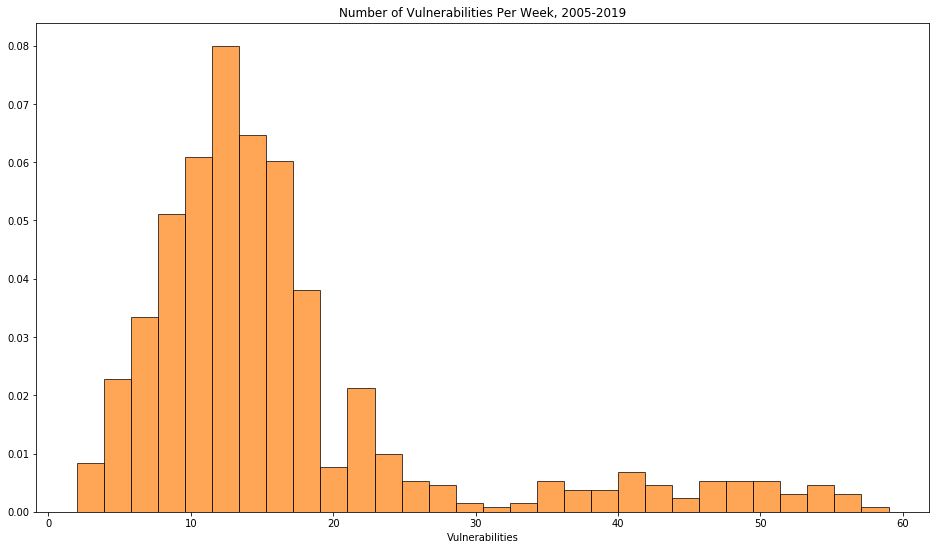

In [78]:
plt.hist(vulnsWeekCount['count'].values, bins=30, density=True, linestyle='solid', color = "C1",alpha=0.7, ec="black")

plt.xlabel('Vulnerabilities')
plt.ylabel('')
plt.title('Number of Vulnerabilities Per Week, 2005-2019')
plt.show()

#### -Fitting Distribution to a Model

In [71]:
mu,std = norm.fit(vulnsWeekCount['count'])

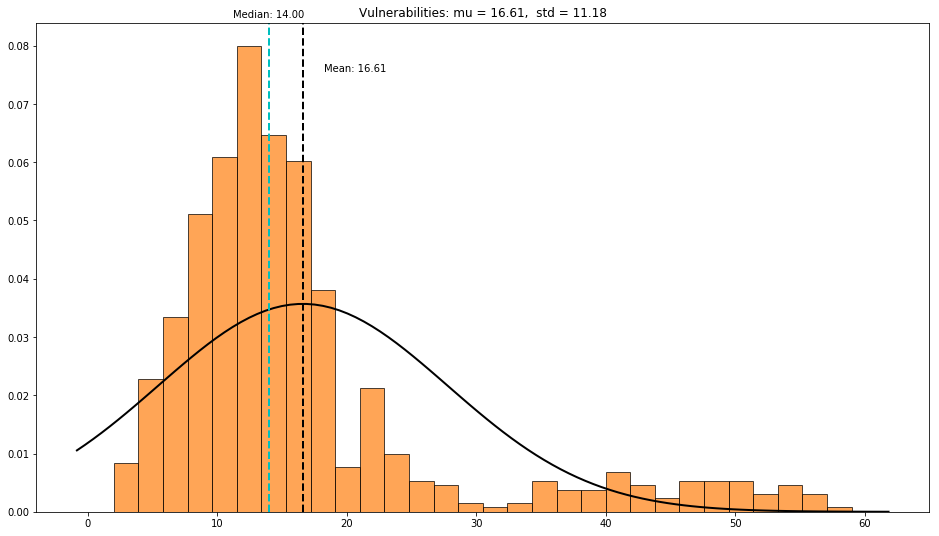

In [117]:
plt.hist(vulnsWeekCount['count'].values, bins=30, density=True, linestyle='solid', color = "C1",alpha=0.7, ec="black")
xlim = plt.xlim()
x = np.linspace(xlim[0], xlim[1], 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Vulnerabilities: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

#Calc Mean and Display
plt.axvline(vulnsWeekCount['count'].mean(), color='k', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(vulnsWeekCount['count'].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(vulnsWeekCount['count'].mean()))

#Calc Median and Display
plt.axvline(vulnsWeekCount['count'].median(), color='c', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(vulnsWeekCount['count'].median()*.8, max_ylim*1.01, 'Median: {:.2f}'.format(vulnsWeekCount['count'].median()))

plt.show()

#### -Model Observations
    - The data is skewed right thus, a normal distribution does not represent the data at the current state. 
#### -Normalizing the Data
    - Taking the Square Root of our dataFrame vulnsWeekCount to hopefully provide a more normal distribution.

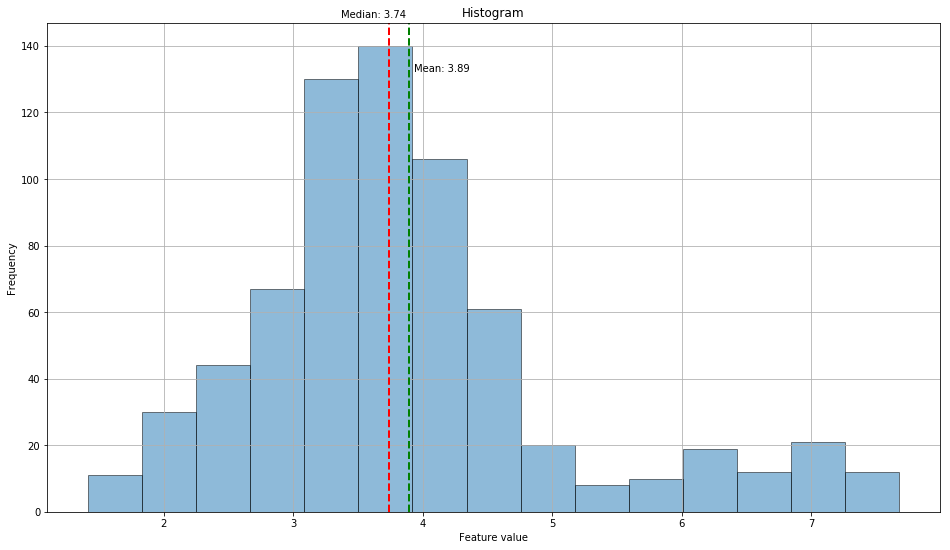

In [132]:
df_pow = vulnsWeekCount.apply(np.sqrt)
df_pow.plot.hist(alpha=0.5, bins=15, grid=True,color = "C0", legend=None, ec="black", linestyle='solid')
plt.xlabel("Feature value")
plt.title("Histogram")

#Calc Mean and Display
plt.axvline(df_pow['count'].mean(), color='g', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(df_pow['count'].mean()*1.01, max_ylim*0.9, 'Mean: {:.2f}'.format(df_pow['count'].mean()))

#Calc Median and Display
plt.axvline(df_pow['count'].median(), color='r', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(df_pow['count'].median()*.9, max_ylim*1.01, 'Median: {:.2f}'.format(df_pow['count'].median()))

plt.show()

#### -Normalizing the Data Cont...
    - Looks like the above histogram resembles a normal curve.
    - Below we spread out the number of points between min and max and fit a Bell Curve to the data.

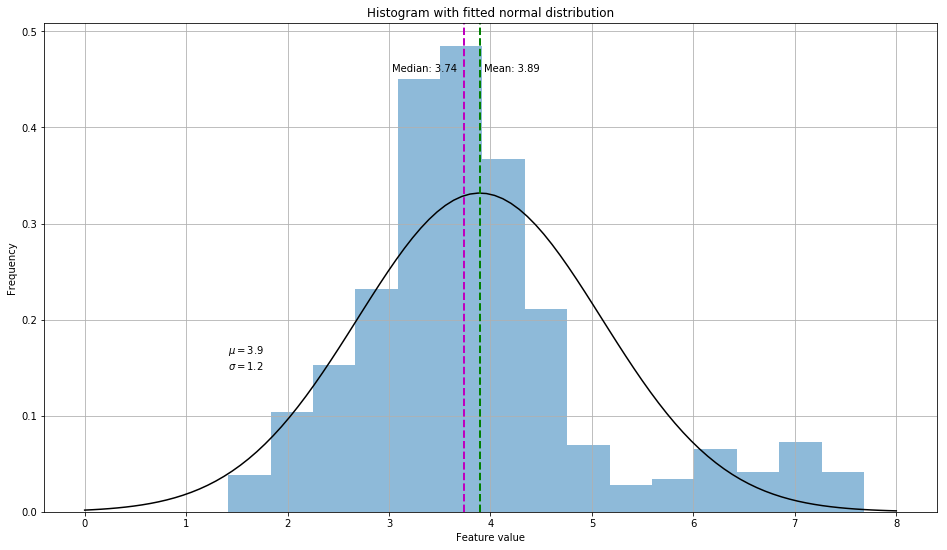

In [155]:
param = stats.norm.fit(df_pow)
#100 units between 0 and 8
x = np.linspace(0, 8, 100)
pdf_fitted = stats.norm.pdf(x, *param)
df_pow.plot.hist(alpha=0.5, bins=15, grid=True, normed=True, legend=None)
plt.text(x=np.min(df_pow), y=0.15, s=r"$\mu=%0.1f$" % param[0] + "\n" + r"$\sigma=%0.1f$" % param[1], color='k')
plt.plot(x, pdf_fitted, color='k')

#Calc Mean and Display
plt.axvline(df_pow['count'].mean(), color='g', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(df_pow['count'].mean()*1.01, max_ylim*0.9, 'Mean: {:.2f}'.format(df_pow['count'].mean()))

#Calc Median and Display
plt.axvline(df_pow['count'].median(), color='m', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(df_pow['count'].median()*.81, max_ylim*0.9, 'Median: {:.2f}'.format(df_pow['count'].median()))

plt.xlabel("Feature value")
plt.title("Histogram with fitted normal distribution")
plt.show()

#### -Normalizing the Data Cont...
    - The above histogram and normalized data can be broken down further into data thats centered around 0 and has a standard deviation of 1.
    - Below we take steps towards scaling the data to fit this criteria.

In [94]:
X_s = preprocessing.StandardScaler().fit_transform(df_pow)
X_s = pd.DataFrame(X_s)   # Put the np array back into a pandas DataFrame for later
print("StandardScaler: %0.3f +/- %0.3f" % (np.mean(X_s), np.std(X_s)))

StandardScaler: 0.000 +/- 1.000


#### -Normalizing the Data Cont...
    - Data centered around 0 and with a standard deviation of 1.

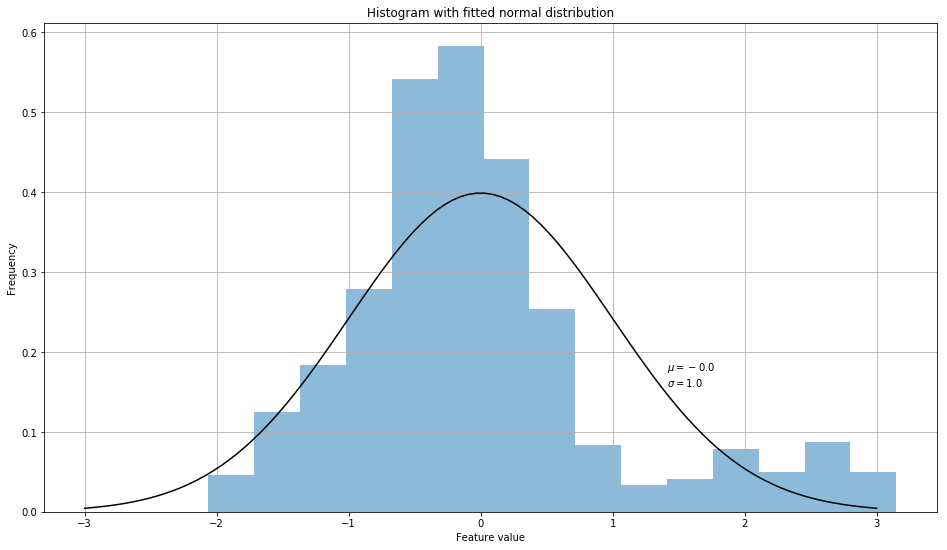

In [156]:
param = stats.norm.fit(X_s)
x = np.linspace(-3, 3, 100)
pdf_fitted = stats.norm.pdf(x, *param)
X_s.plot.hist(alpha=0.5, bins=15, grid=True, normed=True, legend=None)
plt.text(x=np.min(df_pow), y=0.16, s=r"$\mu=%0.1f$" % param[0] + "\n" + r"$\sigma=%0.1f$" % param[1], color='k')

plt.xlabel("Feature value")
plt.title("Histogram with fitted normal distribution")
plt.plot(x, pdf_fitted, color='k')
plt.show()

### Measure of Releases Per Week

In [141]:
ReleasesWeekCount = pd.DataFrame()
ReleasesWeekCount['count'] = release_df['date'].value_counts().resample('w').apply('count')
ReleasesWeekCount.head()

,count
2005-09-18,1
2005-09-25,1
2005-10-02,0
2005-10-09,0
2005-10-16,0


#### -Plotting of New Releases by Week

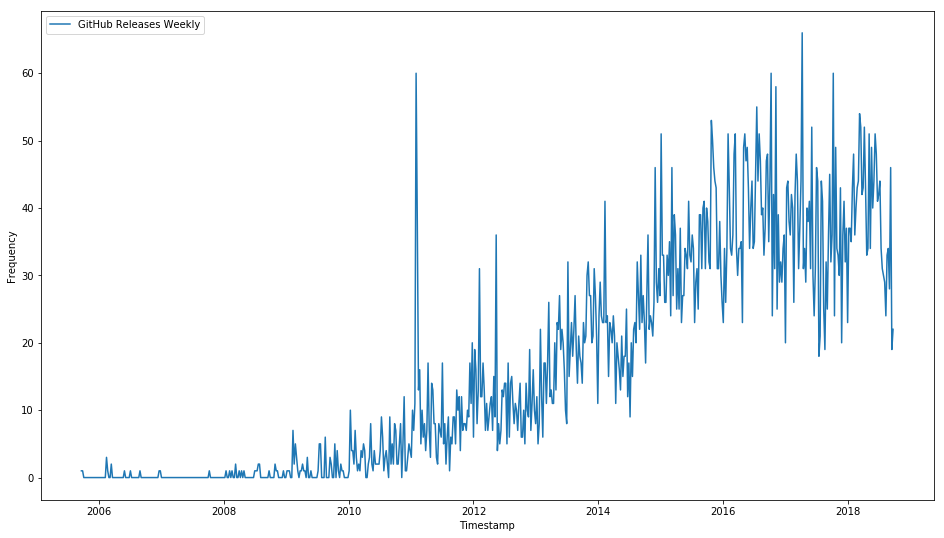

In [53]:
#ReleasesWeekCount.plot()
plt.plot(ReleasesWeekCount, label='GitHub Releases Weekly')
plt.legend(loc='upper left')
plt.xlabel('Timestamp')
plt.ylabel('Frequency')
plt.show()

#### -Basic Statistics on New Releases (Weekly)
       - Mean: 15.860294117647058
       - Median: 10.0
       - Variance: 266.04672745386813
       - Standard Deviation: 16.31093888940389

In [158]:
ReleasesWeekCount_mean = ReleasesWeekCount['count'].mean()
ReleasesWeekCount_med = ReleasesWeekCount['count'].median()
print( ReleasesWeekCount_mean )
print( ReleasesWeekCount_med )
ReleasesWeekCount_variance = stat.variance(ReleasesWeekCount['count'], ReleasesWeekCount_mean)
print(ReleasesWeekCount_variance)
ReleasesWeekCount_stdev = stat.stdev(ReleasesWeekCount['count'])
print(ReleasesWeekCount_stdev)

15.860294117647058
10.0
266.04672745386813
16.31093888940389


#### -Plotting of New Releases by Week & New Vulnerabilities by Week
    - Beginning to look at relationship between the two datasets.
    - Further Statistical analysis will be needed to determine if there is a relation.

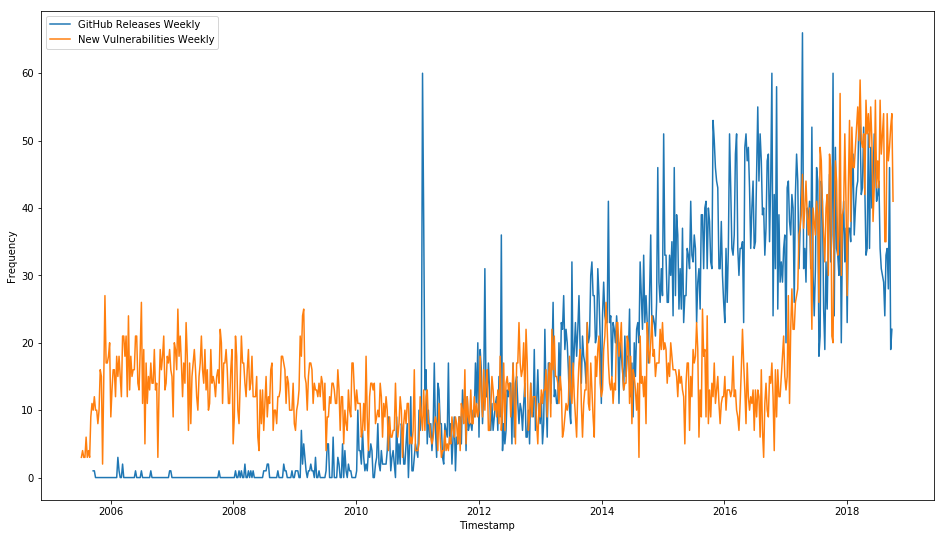

In [51]:
plt.plot(ReleasesWeekCount, label='GitHub Releases Weekly')
plt.plot(vulnsWeekCount, label='New Vulnerabilities Weekly')
plt.legend(loc='upper left')
plt.xlabel('Timestamp')
plt.ylabel('Frequency')
plt.show()